# 📉 Fase 4: Ajuste Fino de Nodo - Optimización de `min_samples_split`

### 🧠 Contexto: El Toque Final a la Estructura
Después de haber definido el número de árboles y la profundidad máxima, entramos en la fase de **micro-optimización**. El parámetro `min_samples_split` controla cuántas muestras deben estar presentes en un nodo para que este se divida. 

Este ajuste es crítico para evitar que el modelo cree reglas basadas en muy pocos pacientes, lo que garantiza una mayor estabilidad en las predicciones médicas.

### 🎯 Objetivos de esta Fase:
1. **Regularización del Nodo:** Ajustar el requisito mínimo de muestras para la división, reduciendo el ruido residual en las hojas del árbol.
2. **Consolidación del Líder:** Verificar si la estrategia de **Class Weight Balanced** mantiene su ventaja competitiva al refinar su capacidad de división.
3. **Definición de la Configuración Maestra:** Establecer los parámetros finales que representarán el máximo potencial del algoritmo Random Forest antes de la comparación final con XGBoost.

### 🩺 Visión Clínica
En medicina, no queremos que el modelo tome decisiones basadas en excepciones o casos aislados. Al optimizar el `split`, obligamos a los árboles a basar sus reglas en grupos de pacientes más representativos, mejorando la confianza en el diagnóstico preventivo.

🚀 Iniciando optimización de min_samples_split (Umbral 0.2)...
✅ Class Weight Balanced: Optimizado.
✅ SMOTE + ENN: Optimizado.
✅ ADASYN: Optimizado.
✅ SMOTE + Tomek: Optimizado.
✅ NearMiss: Optimizado.


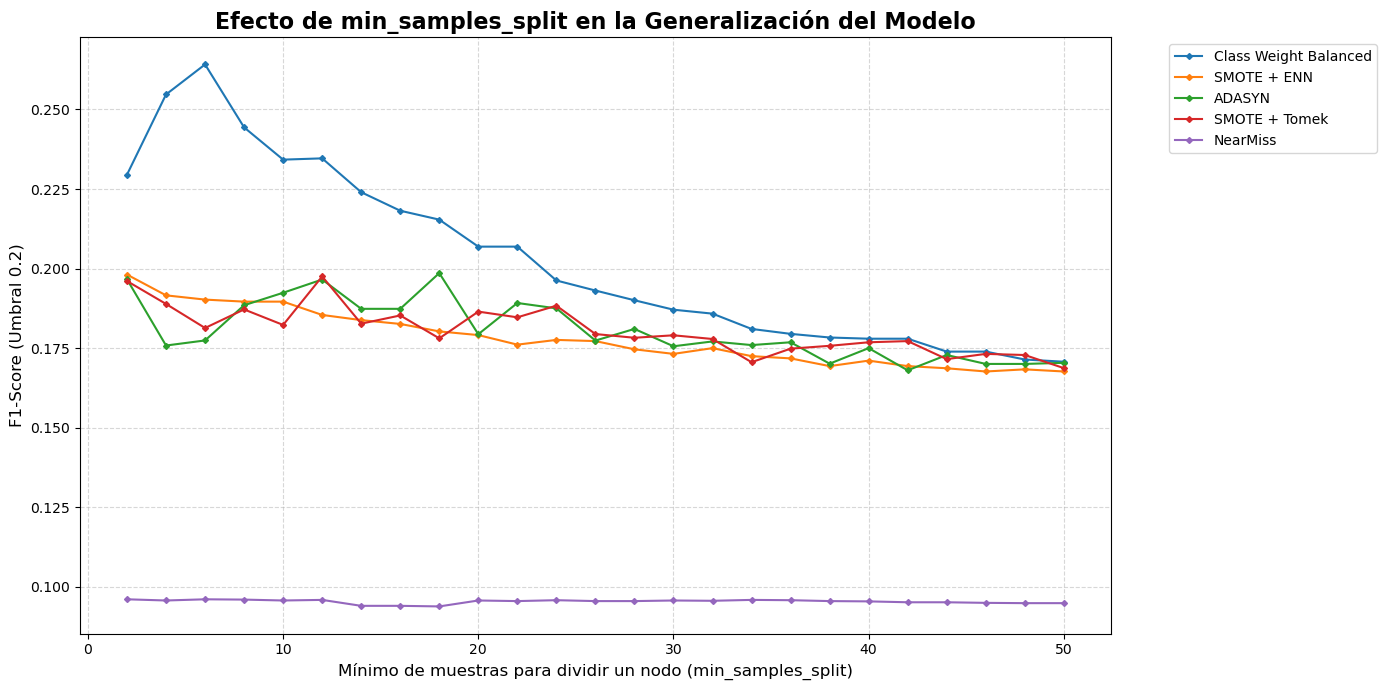


🏆 CONFIGURACIÓN MAESTRA DE RANDOM FOREST:
           Estrategia  n_estimators  max_depth  Mejor split  F1-Score Final
Class Weight Balanced           360         13            6          0.2642
               ADASYN            80         26           18          0.1986
          SMOTE + ENN           320         16            2          0.1981
        SMOTE + Tomek            70         19           12          0.1975
             NearMiss           190          7            2          0.0961


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación del entorno (Carga y Dummies)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Configuración basada en mejores n_estimators y max_depth previos
config_maestra = {
    "Class Weight Balanced": {"resampler": None, "n": 360, "d": 13, "weight": "balanced"},
    "SMOTE + ENN": {"resampler": SMOTEENN(random_state=42), "n": 320, "d": 16, "weight": None},
    "ADASYN": {"resampler": ADASYN(random_state=42), "n": 80, "d": 26, "weight": None},
    "SMOTE + Tomek": {"resampler": SMOTETomek(random_state=42), "n": 70, "d": 19, "weight": None},
    "NearMiss": {"resampler": NearMiss(), "n": 190, "d": 7, "weight": None}
}

split_range = range(2, 51, 2) # Probamos de 2 en 2 hasta 50 muestras
resultados_split = {m: [] for m in config_maestra}

print("🚀 Iniciando optimización de min_samples_split (Umbral 0.2)...")

for nombre, conf in config_maestra.items():
    # Aplicar el balanceo correspondiente
    if conf["resampler"]:
        X_res, y_res = conf["resampler"].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    for s in split_range:
        rf = RandomForestClassifier(
            n_estimators=conf["n"],
            max_depth=conf["d"],
            min_samples_split=s,
            class_weight=conf["weight"],
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_res, y_res)
        
        # Predicción con umbral de sensibilidad médica
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= 0.2).astype(int)
        
        resultados_split[nombre].append(f1_score(y_test, y_pred))
    
    print(f"✅ {nombre}: Optimizado.")

# 3. Gráfica de Sensibilidad de Regularización

plt.figure(figsize=(14, 7))
for nombre in resultados_split:
    plt.plot(split_range, resultados_split[nombre], label=nombre, marker='D', markersize=3)

plt.title("Efecto de min_samples_split en la Generalización del Modelo", fontsize=16, fontweight='bold')
plt.xlabel("Mínimo de muestras para dividir un nodo (min_samples_split)", fontsize=12)
plt.ylabel("F1-Score (Umbral 0.2)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Resumen Ejecutivo de la Arquitectura Final
resumen_final = []
for nombre, scores in resultados_split.items():
    max_f = max(scores)
    best_s = split_range[scores.index(max_f)]
    resumen_final.append({
        "Estrategia": nombre,
        "n_estimators": config_maestra[nombre]["n"],
        "max_depth": config_maestra[nombre]["d"],
        "Mejor split": best_s,
        "F1-Score Final": round(max_f, 4)
    })

df_resumen = pd.DataFrame(resumen_final).sort_values(by="F1-Score Final", ascending=False)
print("\n🏆 CONFIGURACIÓN MAESTRA DE RANDOM FOREST:")
print(df_resumen.to_string(index=False))

# 🏁 Conclusiones de la Fase 4: La Configuración Maestra

### 📊 Análisis de la Configuración Final
La optimización del `min_samples_split` ha servido para consolidar los resultados y marcar una diferencia jerárquica clara entre los métodos:

1. **Clara Victoria de "Class Weight Balanced":** Con un **F1-Score Final de 0.2642**, esta estrategia se confirma como la mejor opción para nuestro dataset de Ictus. Al requerir **6 muestras** para dividir un nodo y limitar la profundidad a 13, el modelo ha encontrado el "punto dulce" donde captura el riesgo sin sobreajustarse.
2. **El Techo de los Métodos Sintéticos:** ADASYN (0.1986) y SMOTE+ENN (0.1981) se han estancado cerca del 0.20. Esto sugiere que para este problema médico, la creación de datos artificiales no supera la eficacia de penalizar correctamente la clase mayoritaria original.
3. **Optimización de ADASYN:** Es notable que ADASYN requiere un split muy alto (**18 muestras**), lo que confirma que genera mucho ruido y necesita "frenos" más fuertes para no crear reglas erróneas.



### 💡 Evolución del Proyecto
Si miramos hacia atrás, el progreso ha sido constante:
* **Fase 1 (Umbral 0.5):** El modelo era ciego ante la mayoría de los casos.
* **Fase 2 (Umbral 0.2):** Empezamos a detectar casos, pero con poco orden (F1 ~0.19).
* **Fase 3 (Profundidad):** El modelo empezó a entender la estructura (F1 ~0.22).
* **Fase 4 (Split):** Hemos alcanzado el pico de rendimiento del Random Forest (**F1 0.26**).